In [1]:
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace
import pandas as pd
from matplotlib import cm
import matplotlib.colors as mcolors
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
newick_file="/Users/npr203/Downloads/chronus_ViPTree.newick"
metadata_file="/Users/npr203/Downloads/6Nov2024_data.tsv"

In [3]:

# Load the Newick tree from a file
with open(newick_file, "r") as file:
    newick_string = file.read().strip()
tree = Tree(newick_string, format=1)
# Count all nodes in the tree
total_nodes = len(tree.get_descendants()) + 1  # Include the root
print(f"Total nodes in the tree: {total_nodes}")

# Configure the circular tree style
ts = TreeStyle()
ts.mode = "c"  # Circular mode
ts.show_leaf_name = True



Total nodes in the tree: 2179


In [4]:
metadata = pd.read_csv(metadata_file, sep="\t")  # Ensure it has columns: name, family, subfamily
metadata=metadata[["Accession", "Description", "Family", "Sub-family", "Genus"]].fillna("NA")
metadata.columns=["Accession", "Description", "Family", "Subfamily", "Genus"]
metadata

additional_rows = [
    {"Accession": "NC_042307", "Description": "Escherichia phage H8", "Family": "Demerecviridae", "Subfamily": "Markadamsvirinae", "Genus": "Tequintavirus"},
    {"Accession": "NC_025444", "Description": "Mycobacterium phage RedRock", "Family": "", "Subfamily": "", "Genus": "Fromanvirus"},
    {"Accession": "NC_048184", "Description": "Synechococcus phage S-CBP3", "Family": "Autographiviridae", "Subfamily": "", "Genus": "Lirvirus"},
    {"Accession": "NC_055743.1", "Description": "Query", "Family": "Query", "Subfamily": "Query", "Genus": "Query"},
]

# Convert the list of rows into a DataFrame and append to metadata
additional_df = pd.DataFrame(additional_rows)
metadata = pd.concat([metadata, additional_df], ignore_index=True)




In [5]:
# Specify the target node name and distance threshold
target_node_name = "NC_055743"  # Replace with your desired node name
distance_threshold = .96  # Set your desired distance threshold

# Find the target node
target_node = tree.search_nodes(name=target_node_name)
if not target_node:
    raise ValueError(f"Node with name '{target_node_name}' not found in the tree.")
target_node = target_node[0]  # Retrieve the node object

# Get all leaves within the distance threshold from the target node
leaves_within_threshold = [
    leaf.name
    for leaf in tree.iter_leaves()
    if tree.get_distance(target_node, leaf) <= distance_threshold
]

# # Prune the tree to keep only these leaves
pruned_tree = tree.copy()
pruned_tree.prune(leaves_within_threshold, preserve_branch_length=True)

total_nodes = len(pruned_tree.get_descendants()) + 1  # Include the root
print(f"Total nodes in the tree: {total_nodes}")





Total nodes in the tree: 869


In [6]:
def generate_colors(categories):
    cmap = cm.get_cmap("tab20", len(categories))  # Use a color map with sufficient variety
    return {category: mcolors.to_hex(cmap(i)) for i, category in enumerate(categories)}


acc_list=[]
# Map metadata to the tree
for node in pruned_tree.iter_leaves():
    name = node.name
    if name in metadata["Accession"].values:
        acc_list.append(name)
        node.add_feature("Family", metadata.loc[metadata["Accession"] == name, "Family"].values[0])
        node.add_feature("Subfamily", metadata.loc[metadata["Accession"] == name, "Subfamily"].values[0])
    else:
        print(name)
        node.add_feature("Family", "NA")
        node.add_feature("Subfamily", "NA")

metadata[metadata["Accession"].isin(acc_list)].to_csv("/Users/npr203/Downloads/metadata_ViPTree.csv", sep="\t", index=False)
metadata_filtered=metadata[metadata["Accession"].isin(acc_list)]
# family_colors = generate_colors(list(metadata_filtered["Family"].unique()) + list(metadata_filtered["Subfamily"].unique()))
family_colors = generate_colors(metadata_filtered["Family"].unique())
subfamily_colors = generate_colors(metadata_filtered["Subfamily"].unique())


# family_colors={'Straboviridae': '#118ab2ff',
#  'Unclassified': '#ffffff',
#  'Kyanoviridae': '#06d6a0ff',
#  'Ackermannviridae': '#ffd166ff',
#  'Query': '#e83f6fff'}

# subfamily_colors= {'Tevenvirinae': '#1f77b4',
#  'Unclassified': '#ffffff',
#  'Aglimvirinae': '#d62728',
#  'Cvivirinae': '#8c564b',
#  'Twarogvirinae': '#f7b6d2',
#  'Emmerichvirinae': '#bcbd22',
#  'Query': '#e83f6fff'}
 
print(family_colors)
# print(subfamily_colors)

# Style the nodes
for node in pruned_tree.iter_leaves():
    nstyle = NodeStyle()
    nstyle["size"] = 10  # Size of the node
    # nstyle["fgcolor"] = family_colors.get(node.Family, "black")  # Family color
    # nstyle["bgcolor"] = subfamily_colors.get(node.Subfamily, "white")  # Subfamily color
    nstyle["fgcolor"] = subfamily_colors.get(node.Subfamily, "white")  # Subfamily color
    nstyle["hz_line_color"] = family_colors.get(node.Family, "black") # Edge color
    nstyle["hz_line_width"] = 5
    # nstyle["size"] = 40

    node.set_style(nstyle)



# Configure the circular tree style
ts = TreeStyle()
ts.mode = "c"  # Circular mode
ts.show_leaf_name = True


print(len(acc_list))
# acc_list

# Add legend
for family, color in family_colors.items():
    ts.legend.add_face(faces.TextFace(f"{family} (Family)", fsize=40), column=0)
    ts.legend.add_face(faces.CircleFace(14, color), column=1)

for subfamily, color in subfamily_colors.items():
    ts.legend.add_face(faces.TextFace(f"{subfamily} (Subfamily)", fsize=40), column=0)
    ts.legend.add_face(faces.CircleFace(14, color), column=1)


# # Search for the target node in the tree
# target_node = pruned_tree.search_nodes(name=target_node_name)

# if target_node:
#     target_node = target_node[0]  # Get the first (and only) result
    
#     # Get all leaves in the tree
#     all_leaves = pruned_tree.get_leaves()
    
#     # Remove the target node and its descendants
#     leaves_to_keep = [leaf.name for leaf in all_leaves if leaf != target_node]
    
#     # Prune the tree to keep only the remaining leaves
#     pruned_tree.prune(leaves_to_keep, preserve_branch_length=True)
#     print(f"Node {target_node_name} and its descendants have been removed.")
# else:
#     print(f"Node {target_node_name} not found.")

    
# # Render the tree
pruned_tree.show(tree_style=ts)
# pruned_tree.render('mytree2.svg',tree_style=ts)


/var/folders/h7/qg__3pn97f1clj4jcxdkjxh00000gp/T/ipykernel_83215/3049751582.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(categories))  # Use a color map with sufficient variety


{'Straboviridae': '#1f77b4', 'Unclassified': '#98df8a', 'Kyanoviridae': '#8c564b', 'Ackermannviridae': '#c7c7c7', 'Query': '#9edae5'}
435


2025-01-30 14:55:13.503 python[83215:1530715] +[IMKClient subclass]: chose IMKClient_Modern


In [ ]:
def generate_colors(categories):
    cmap = cm.get_cmap("tab20", len(categories))  # Use a color map with sufficient variety
    return {category: mcolors.to_hex(cmap(i)) for i, category in enumerate(categories)}


acc_list=[]
# Map metadata to the tree
for node in pruned_tree.iter_leaves():
    name = node.name
    if name in metadata["Accession"].values:
        acc_list.append(name)
        node.add_feature("Family", metadata.loc[metadata["Accession"] == name, "Family"].values[0])
        node.add_feature("Subfamily", metadata.loc[metadata["Accession"] == name, "Subfamily"].values[0])
    else:
        print(name)
        node.add_feature("Family", "NA")
        node.add_feature("Subfamily", "NA")

metadata[metadata["Accession"].isin(acc_list)].to_csv("/Users/npr203/Downloads/metadata_ViPTree.csv", sep="\t", index=False)
metadata_filtered=metadata[metadata["Accession"].isin(acc_list)]
# family_colors = generate_colors(list(metadata_filtered["Family"].unique()) + list(metadata_filtered["Subfamily"].unique()))
family_colors = generate_colors(metadata_filtered["Family"].unique())
subfamily_colors = generate_colors(metadata_filtered["Subfamily"].unique())


# family_colors={'Straboviridae': '#118ab2ff',
#  'Unclassified': '#ffffff',
#  'Kyanoviridae': '#06d6a0ff',
#  'Ackermannviridae': '#ffd166ff',
#  'Query': '#e83f6fff'}

# subfamily_colors= {'Tevenvirinae': '#1f77b4',
#  'Unclassified': '#ffffff',
#  'Aglimvirinae': '#d62728',
#  'Cvivirinae': '#8c564b',
#  'Twarogvirinae': '#f7b6d2',
#  'Emmerichvirinae': '#bcbd22',
#  'Query': '#e83f6fff'}
 
print(family_colors)
# print(subfamily_colors)

# Style the nodes
for node in pruned_tree.iter_leaves():
    nstyle = NodeStyle()
    nstyle["size"] = 10  # Size of the node
    # nstyle["fgcolor"] = family_colors.get(node.Family, "black")  # Family color
    # nstyle["bgcolor"] = subfamily_colors.get(node.Subfamily, "white")  # Subfamily color
    nstyle["fgcolor"] = subfamily_colors.get(node.Subfamily, "white")  # Subfamily color
    nstyle["hz_line_color"] = family_colors.get(node.Family, "black") # Edge color
    nstyle["hz_line_width"] = 5
    # nstyle["size"] = 40

    node.set_style(nstyle)



# Configure the circular tree style
ts = TreeStyle()
ts.mode = "c"  # Circular mode
ts.show_leaf_name = True


print(len(acc_list))
# acc_list

# Add legend
for family, color in family_colors.items():
    ts.legend.add_face(faces.TextFace(f"{family} (Family)", fsize=40), column=0)
    ts.legend.add_face(faces.CircleFace(14, color), column=1)

for subfamily, color in subfamily_colors.items():
    ts.legend.add_face(faces.TextFace(f"{subfamily} (Subfamily)", fsize=40), column=0)
    ts.legend.add_face(faces.CircleFace(14, color), column=1)


# # Search for the target node in the tree
# target_node = pruned_tree.search_nodes(name=target_node_name)

# if target_node:
#     target_node = target_node[0]  # Get the first (and only) result
    
#     # Get all leaves in the tree
#     all_leaves = pruned_tree.get_leaves()
    
#     # Remove the target node and its descendants
#     leaves_to_keep = [leaf.name for leaf in all_leaves if leaf != target_node]
    
#     # Prune the tree to keep only the remaining leaves
#     pruned_tree.prune(leaves_to_keep, preserve_branch_length=True)
#     print(f"Node {target_node_name} and its descendants have been removed.")
# else:
#     print(f"Node {target_node_name} not found.")

    
# # Render the tree
pruned_tree.show(tree_style=ts)
# pruned_tree.render('mytree2.svg',tree_style=ts)


/var/folders/h7/qg__3pn97f1clj4jcxdkjxh00000gp/T/ipykernel_83215/3049751582.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(categories))  # Use a color map with sufficient variety


{'Straboviridae': '#1f77b4', 'Unclassified': '#98df8a', 'Kyanoviridae': '#8c564b', 'Ackermannviridae': '#c7c7c7', 'Query': '#9edae5'}
435


2025-01-30 14:55:13.503 python[83215:1530715] +[IMKClient subclass]: chose IMKClient_Modern


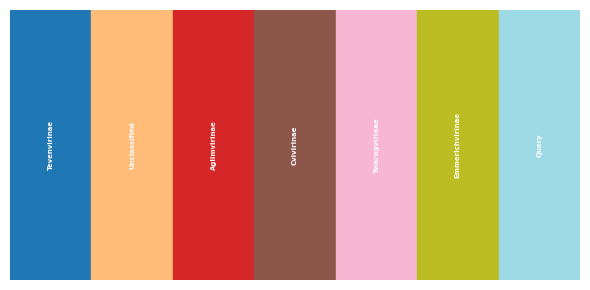

In [19]:
def plot_palette(palette):
   # Show the colors in a plot
   fig, ax = plt.subplots(figsize=(6, 3))
   # Displaying each color with corresponding genus name
   for i, (genus, color) in enumerate(palette.items()):
      ax.add_patch(plt.Rectangle((i / len(palette), 0), 1 / len(palette), 1, color=color))
      ax.text((i + 0.5) / len(palette), 0.5, genus.replace(" ", "\n"), ha='center', va='center', color='white', fontsize=5, fontweight='bold', rotation=90)

   # ax.set_xlim(0, 1)
   # ax.set_ylim(0, 1)
   ax.axis('off')  # Hide axis
   plt.tight_layout()

   plt.show()


plot_palette(subfamily_colors)

family_colors

In [15]:
{'Tevenvirinae': '#1f77b4',
 'Unclassified': '#ffffff',
 'Aglimvirinae': '#d62728',
 'Cvivirinae': '#8c564b',
 'Twarogvirinae': '#f7b6d2',
 'Emmerichvirinae': '#bcbd22',
 'Query': '#e83f6fff'}

{'Tevenvirinae': '#1f77b4',
 'Unclassified': '#ffbb78',
 'Aglimvirinae': '#d62728',
 'Cvivirinae': '#8c564b',
 'Twarogvirinae': '#f7b6d2',
 'Emmerichvirinae': '#bcbd22',
 'Query': '#9edae5'}

In [13]:
family_colors

{'Straboviridae': '#1f77b4',
 'Unclassified': '#c5b0d5',
 'Arenbergviridae': '#aec7e8',
 'Grimontviridae': '#ff7f0e',
 'Kyanoviridae': '#ff7f0e',
 'Pootjesviridae': '#ffbb78',
 'Naomviridae': '#2ca02c',
 'Ackermannviridae': '#98df8a',
 'Demerecviridae': '#98df8a',
 'Schitoviridae': '#d62728',
 'Zobellviridae': '#ff9896',
 'Query': '#9edae5',
 'Tevenvirinae': '#9467bd',
 'Ounavirinae': '#8c564b',
 'Staniewskivirinae': '#c49c94',
 'Stephanstirmvirinae': '#c49c94',
 'Aglimvirinae': '#e377c2',
 'Cvivirinae': '#f7b6d2',
 'Twarogvirinae': '#7f7f7f',
 'Markadamsvirinae': '#7f7f7f',
 'Eucampyvirinae': '#c7c7c7',
 'Emmerichvirinae': '#bcbd22',
 'Mccorquodalevirinae': '#dbdb8d',
 'Pontosvirinae': '#dbdb8d',
 'Ermolyevavirinae': '#17becf',
 'Vequintavirinae': '#9edae5'}

In [55]:
cluster_df=pd.read_csv("/Users/npr203/Downloads/VipTree_cluster.tsv", sep="\t", names=["clust", "mem"])
cluster_df["genome"]=cluster_df["mem"].str.split("_CDS").str[0].str.split(".").str[0]
cluster_df_grouped=cluster_df.groupby(["clust", "genome"]).first().reset_index()
cluster_df_grouped

,clust,genome,mem
0,HE858210.2_CDS_0007,HE858210,HE858210.2_CDS_0007
1,HE858210.2_CDS_0007,HE981739,HE981739.1_CDS_0007
2,HE858210.2_CDS_0007,NC_007023,NC_007023.1_CDS_0006
3,HE858210.2_CDS_0007,NC_014467,NC_014467.1_CDS_0007
4,HE858210.2_CDS_0007,NC_021344,NC_021344.2_CDS_0008
...,...,...,...
64128,NC_070937.1_CDS_0267,NC_028773,NC_028773.1_CDS_0135
64129,NC_070937.1_CDS_0267,NC_070937,NC_070937.1_CDS_0267
64130,NC_070937.1_CDS_0268,NC_028773,NC_028773.1_CDS_0136
64131,NC_070937.1_CDS_0268,NC_055721,NC_055721.1_CDS_0272


In [43]:
pivot_df = cluster_df_grouped.pivot(index="genome", columns="clust", values="mem").notnull().astype(int)
pivot_df

clust,HE858210.2_CDS_0007,HE858210.2_CDS_0009,HE858210.2_CDS_0012,HE858210.2_CDS_0015,HE858210.2_CDS_0016,HE858210.2_CDS_0019,HE858210.2_CDS_0026,HE858210.2_CDS_0030,HE858210.2_CDS_0034,HE858210.2_CDS_0036,...,NC_070937.1_CDS_0258,NC_070937.1_CDS_0259,NC_070937.1_CDS_0260,NC_070937.1_CDS_0261,NC_070937.1_CDS_0262,NC_070937.1_CDS_0263,NC_070937.1_CDS_0264,NC_070937.1_CDS_0266,NC_070937.1_CDS_0267,NC_070937.1_CDS_0268
genome,,,,,,,,,,,,,,,,,,,,,
HE858210,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
HE981739,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
HM137666,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
JN849462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KJ477684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC_070777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NC_070778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NC_070779,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# Merge with metadata to add 'Subfamily' information
pivot_with_metadata = pivot_df.reset_index()
pivot_with_metadata = pd.merge(
    pivot_with_metadata, metadata_filtered[["Accession", "Subfamily"]], how="left", left_on="genome", right_on="Accession"
)
pivot_with_metadata

,genome,HE858210.2_CDS_0007,HE858210.2_CDS_0009,HE858210.2_CDS_0012,HE858210.2_CDS_0015,HE858210.2_CDS_0016,HE858210.2_CDS_0019,HE858210.2_CDS_0026,HE858210.2_CDS_0030,HE858210.2_CDS_0034,...,NC_070937.1_CDS_0260,NC_070937.1_CDS_0261,NC_070937.1_CDS_0262,NC_070937.1_CDS_0263,NC_070937.1_CDS_0264,NC_070937.1_CDS_0266,NC_070937.1_CDS_0267,NC_070937.1_CDS_0268,Accession,Subfamily
0,HE858210,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,HE858210,Unclassified
1,HE981739,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,HE981739,Unclassified
2,HM137666,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,HM137666,Tevenvirinae
3,JN849462,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,JN849462,Unclassified
4,KJ477684,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,KJ477684,Tevenvirinae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,NC_070777,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NC_070777,Tevenvirinae
234,NC_070778,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NC_070778,Tevenvirinae
235,NC_070779,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NC_070779,Tevenvirinae
236,NC_070780,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NC_070780,Tevenvirinae


KeyboardInterrupt: 

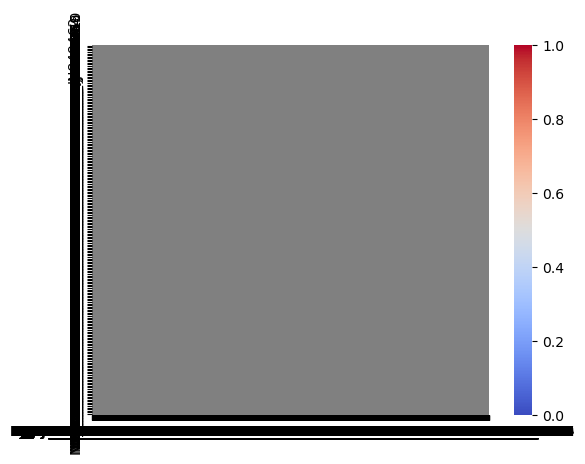

In [54]:
# Map colors for heatmap
subfamily_colors = {
    'Tevenvirinae': '#1f77b4',
    'Unclassified': '#ffffff',
    'Aglimvirinae': '#d62728',
    'Cvivirinae': '#8c564b',
    'Twarogvirinae': '#f7b6d2',
    'Emmerichvirinae': '#bcbd22',
    'Query': '#e83f6fff'
}

# Get a list of colors for each row in the heatmap based on Subfamily
row_colors = pivot_with_metadata["Subfamily"].map(subfamily_colors)
row_colors
# Plot heatmap
sns.heatmap(
    pivot_df, 
    cmap="coolwarm",  # Use a diverging colormap for better visibility
    cbar=True,        # Show the color bar for clarity
    linewidths=0.5, 
    linecolor="gray",
    square=False,     # Make cells rectangular if needed
    xticklabels=True, # Show genome names on the x-axis
    yticklabels=True  # Show cluster names on the y-axis
)

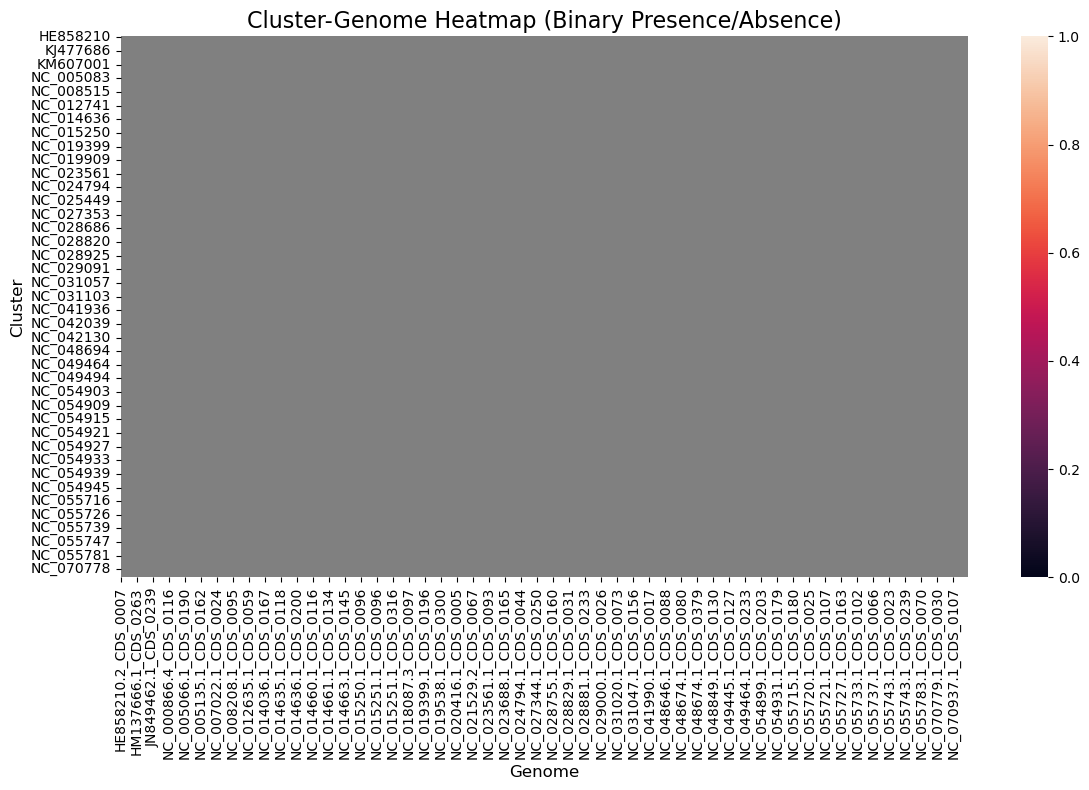

In [ ]:
# plt.figure(figsize=(12, 8))
# sns.heatmap(
#     pivot_df, 
#     # cmap="Greys",  # Use a grayscale heatmap since we're only showing 0 and 1
#     linewidths=0.5, 
#     linecolor="gray"
# )

# plt.title("Cluster-Genome Heatmap (Binary Presence/Absence)", fontsize=16)
# plt.xlabel("Genome", fontsize=12)
# plt.ylabel("Cluster", fontsize=12)
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()